# Qiskit Lab3

In [1]:
from qiskit import *
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

## Part 1: Quantum circuit for Shor's algorithm

Construct a compiled version of quantum circuit for Shor's algorithm.

Shor's algorithm consists of the following steps; choose a co-prime 
$a$, where $a \in [2,N-1]$ and the greatest common divisor of  $a$ and $N$ is 1, find the order of $a$ modulo $N$, the smallest integer $r$
such that $a^r \mod N=1$, and then obtain the factor of $N$ by computing the greatst common divisor of $a^{r/2} \pm 1$ and $N$. In this procedure, the second step, finding the order of $a$ modulo $N$, is the only quantum part, quantum order-finding.

In Ch.3.9 Shor's Algorithm, we built a quantum circuit to find the order for $a=7$ and $N=15$. However, as we are very well aware by now, such a large depth circuit is not practical to run on near-term quantum systems due to the presence of noise. Here in part 1 of this lab, we construct a practical quantum circuit for the same example, which could generate a meaningful solution when executed on today's quantum computers.

In general, the quantum order-finding circuit to factorize the number $N$ requires $m=\log_2(N)$ qubits in the computational (auxiliary) register and 
$2m(=t)$ qubit in the period (counting) registers .i.e. total $3m$ qubits, at minimum. Therefore, $12$ qubits were used in the quantum circuit to factorize the number 15 in Ch.3.9 Shor's Algorithm. In addition, the cotrolled unitary operator for the modular function, $f(x)=a^{x} \mod N$ was applied in a cascading manner as shown in the figure below to produce the highly entangled state $\sum_{x=0}^{2^m-1}\ket{x}\ket{a^x \mod N}$, which increseas the circuit depth substantially. However the size of the circuit can be reduced based on several observations.

In [2]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)

# Check the correctness of 7 mod 15 circuit

In [6]:

# Quantum Circuit for 7x mod 15
def create_7mod15_circuit():
    m = 4
    U_qc = QuantumCircuit(m)
    U_qc.x(range(m))
    U_qc.swap(1, 2)
    U_qc.swap(2, 3)
    U_qc.swap(0, 3)
    return U_qc

sim=AerSimulator()
# Test all 4-qubit inputs
for i in range(1,15):
    qc = QuantumCircuit(4, 4)
    # Setting the input
    binary_input = format(i, '04b')
    for j, bit in enumerate(reversed(binary_input)):
        if bit == '1':
            qc.x(j)

    # Apply 7x mod 15 operation
    U_qc = create_7mod15_circuit()
    qc.append(U_qc, [0, 1, 2, 3])

    # Measure the output
    qc.measure([0, 1, 2, 3], [0, 1, 2, 3])

    
    transpiled_circuit = transpile(qc, sim)
    job = sim.run(transpiled_circuit, shots=1) # Run the circuit 1 times 
    counts= job.result().get_counts() 

    measured_output = max(counts, key=counts.get)  # Get the most frequent measurement result

    # Expected output
    expected_output = format((7 * i) % 15, '04b')

    print(f"Input: {binary_input}, Expected: {expected_output}, Measured: {measured_output}")


Input: 0001, Expected: 0111, Measured: 0111
Input: 0010, Expected: 1110, Measured: 1110
Input: 0011, Expected: 0110, Measured: 0110
Input: 0100, Expected: 1101, Measured: 1101
Input: 0101, Expected: 0101, Measured: 0101
Input: 0110, Expected: 1100, Measured: 1100
Input: 0111, Expected: 0100, Measured: 0100
Input: 1000, Expected: 1011, Measured: 1011
Input: 1001, Expected: 0011, Measured: 0011
Input: 1010, Expected: 1010, Measured: 1010
Input: 1011, Expected: 0010, Measured: 0010
Input: 1100, Expected: 1001, Measured: 1001
Input: 1101, Expected: 0001, Measured: 0001
Input: 1110, Expected: 1000, Measured: 1000


In [7]:
def cU_multi(k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    return cU_multi

In [8]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [9]:
# QPE circuit for Shor
t = 3 
shor_QPE = QuantumCircuit(t+m, t)
shor_QPE.h(range(t))

shor_QPE.x(t)
for idx in range(t-1):
    shor_QPE.append(cU_multi(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_QPE.append(qft_dag, range(t))
shor_QPE.measure(range(t), range(t))

shor_QPE.draw()

┌───┐                                  ┌───────┐┌─┐      
q_0: ┤ H ├────────■─────────────────────────┤0      ├┤M├──────
     ├───┤        │                         │       │└╥┘┌─┐   
q_1: ┤ H ├────────┼────────────────■────────┤1 QFT+ ├─╫─┤M├───
     ├───┤        │                │        │       │ ║ └╥┘┌─┐
q_2: ┤ H ├────────┼────────────────┼────────┤2      ├─╫──╫─┤M├
     ├───┤┌───────┴───────┐┌───────┴───────┐└───────┘ ║  ║ └╥┘
q_3: ┤ X ├┤0              ├┤0              ├──────────╫──╫──╫─
     └───┘│               ││               │          ║  ║  ║ 
q_4: ─────┤1              ├┤1              ├──────────╫──╫──╫─
          │  7Mod15_[2^0] ││  7Mod15_[2^1] │          ║  ║  ║ 
q_5: ─────┤2              ├┤2              ├──────────╫──╫──╫─
          │               ││               │          ║  ║  ║ 
q_6: ─────┤3              ├┤3              ├──────────╫──╫──╫─
          └───────────────┘└───────────────┘          ║  ║  ║ 
c: 3/═════════════════════════════════════════════════╩══╩══╩═
                                                      0  1  2

In [10]:
def cU_multi(k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    return cU_multi

In [11]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [12]:
# QPE circuit for Shor
t = 3 
shor_QPE = QuantumCircuit(t+m, t)
shor_QPE.h(range(t))

shor_QPE.x(t)
for idx in range(t-1):
    shor_QPE.append(cU_multi(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_QPE.append(qft_dag, range(t))
shor_QPE.measure(range(t), range(t))

shor_QPE.draw()

┌───┐                                  ┌───────┐┌─┐      
q_0: ┤ H ├────────■─────────────────────────┤0      ├┤M├──────
     ├───┤        │                         │       │└╥┘┌─┐   
q_1: ┤ H ├────────┼────────────────■────────┤1 QFT+ ├─╫─┤M├───
     ├───┤        │                │        │       │ ║ └╥┘┌─┐
q_2: ┤ H ├────────┼────────────────┼────────┤2      ├─╫──╫─┤M├
     ├───┤┌───────┴───────┐┌───────┴───────┐└───────┘ ║  ║ └╥┘
q_3: ┤ X ├┤0              ├┤0              ├──────────╫──╫──╫─
     └───┘│               ││               │          ║  ║  ║ 
q_4: ─────┤1              ├┤1              ├──────────╫──╫──╫─
          │  7Mod15_[2^0] ││  7Mod15_[2^1] │          ║  ║  ║ 
q_5: ─────┤2              ├┤2              ├──────────╫──╫──╫─
          │               ││               │          ║  ║  ║ 
q_6: ─────┤3              ├┤3              ├──────────╫──╫──╫─
          └───────────────┘└───────────────┘          ║  ║  ║ 
c: 3/═════════════════════════════════════════════════╩══╩══╩═
                                                      0  1  2

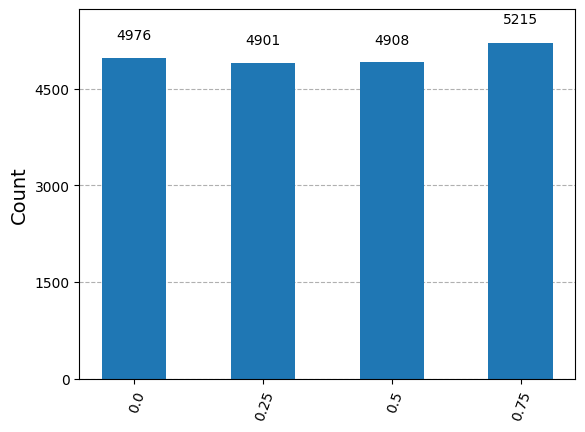

In [15]:
sim = AerSimulator()
transpiled_circuit = transpile(shor_QPE, sim)
shots=20000
job = sim.run(transpiled_circuit, shots=shots) # Run the circuit 1000 times 
count_QPE= job.result().get_counts() 


key_new = [str(int(key,2)/2**t) for key in count_QPE.keys()]
count_new_QPE = dict(zip(key_new, count_QPE.values()))
large_num={}
for key in count_new_QPE.keys():
    if count_new_QPE[key]>400:
        large_num[key]=count_new_QPE[key]

plot_histogram(large_num)

# Use iterative phase estimation

In [17]:
# m is the number of qubit to represent mod
m = 4
# t is the number of digit of the final phase result
t=5
q = QuantumRegister(m+1)
c = ClassicalRegister(t)
shor_IPE = QuantumCircuit(q,c)

shor_IPE.x(1)
for k in range(1,t+1):

    shor_IPE.reset(q[0])
    shor_IPE.h(0)

    ##2 phase correction

    for j in range(t-k+2,t+1):
        shor_IPE.cp(-2*np.pi*(1/(2**(j-t+k))),0,1).c_if(c[t-j],1)
        
    ##3 Apply control-U operator as many times as needed 
        
    shor_IPE.append(cU_multi(t-k), [0]+ list(range(1,1+m)))
    
    ##4 measure the anscillar qubit in x-basis
    
    
    shor_IPE.h(0)
    shor_IPE.measure(0,k-1)

shor_IPE.draw()

┌───┐                 ┌───┐┌─┐     ┌───┐                 »
q73_0: ─|0>─┤ H ├────────■────────┤ H ├┤M├─|0>─┤ H ├────────■────────»
       ┌───┐└───┘┌───────┴───────┐└───┘└╥┘     └───┘        │P(-π/2) »
q73_1: ┤ X ├─────┤0              ├──────╫───────────────────■────────»
       └───┘     │               │      ║                   ║        »
q73_2: ──────────┤1              ├──────╫───────────────────╫────────»
                 │  7Mod15_[2^4] │      ║                   ║        »
q73_3: ──────────┤2              ├──────╫───────────────────╫────────»
                 │               │      ║                   ║        »
q73_4: ──────────┤3              ├──────╫───────────────────╫────────»
                 └───────────────┘      ║              ┌────╨─────┐  »
 c1: 5/═════════════════════════════════╩══════════════╡ c1_0=0x1 ╞══»
                                        0              └──────────┘  »
«                        ┌───┐┌─┐     ┌───┐                                  »
«q73_0: ────────■────────┤ H ├┤M├─|0>─┤ H ├────────■────────────────■────────»
«       ┌───────┴───────┐└───┘└╥┘     └───┘        │P(-π/2)         │P(-π/4) »
«q73_1: ┤0              ├──────╫───────────────────■────────────────■────────»
«       │               │      ║                   ║                ║        »
«q73_2: ┤1              ├──────╫───────────────────╫────────────────╫────────»
«       │  7Mod15_[2^3] │      ║                   ║                ║        »
«q73_3: ┤2              ├──────╫───────────────────╫────────────────╫────────»
«       │               │      ║                   ║                ║        »
«q73_4: ┤3              ├──────╫───────────────────╫────────────────╫────────»
«       └───────────────┘      ║              ┌────╨─────┐     ┌────╨─────┐  »
« c1: 5/═══════════════════════╩══════════════╡ c1_1=0x1 ╞═════╡ c1_0=0x1 ╞══»
«                              1              └──────────┘     └──────────┘  »
«                        ┌───┐┌─┐     ┌───┐                                  »
«q73_0: ────────■────────┤ H ├┤M├─|0>─┤ H ├────────■────────────────■────────»
«       ┌───────┴───────┐└───┘└╥┘     └───┘        │P(-π/2)         │P(-π/4) »
«q73_1: ┤0              ├──────╫───────────────────■────────────────■────────»
«       │               │      ║                   ║                ║        »
«q73_2: ┤1              ├──────╫───────────────────╫────────────────╫────────»
«       │  7Mod15_[2^2] │      ║                   ║                ║        »
«q73_3: ┤2              ├──────╫───────────────────╫────────────────╫────────»
«       │               │      ║                   ║                ║        »
«q73_4: ┤3              ├──────╫───────────────────╫────────────────╫────────»
«       └───────────────┘      ║              ┌────╨─────┐     ┌────╨─────┐  »
« c1: 5/═══════════════════════╩══════════════╡ c1_2=0x1 ╞═════╡ c1_1=0x1 ╞══»
«                              2              └──────────┘     └──────────┘  »
«                                         ┌───┐┌─┐     ┌───┐                 »
«q73_0: ────────■────────────────■────────┤ H ├┤M├─|0>─┤ H ├────────■────────»
«               │P(-π/8) ┌───────┴───────┐└───┘└╥┘     └───┘        │P(-π/2) »
«q73_1: ────────■────────┤0              ├──────╫───────────────────■────────»
«               ║        │               │      ║                   ║        »
«q73_2: ────────╫────────┤1              ├──────╫───────────────────╫────────»
«               ║        │  7Mod15_[2^1] │      ║                   ║        »
«q73_3: ────────╫────────┤2              ├──────╫───────────────────╫────────»
«               ║        │               │      ║                   ║        »
«q73_4: ────────╫────────┤3              ├──────╫───────────────────╫────────»
«          ┌────╨─────┐  └───────────────┘      ║              ┌────╨─────┐  »
« c1: 5/═══╡ c1_0=0x1 ╞═════════════════════════╩══════════════╡ c1_3=0x1 ╞══»
«          └──────────┘                         3              └──────────┘  »
«       

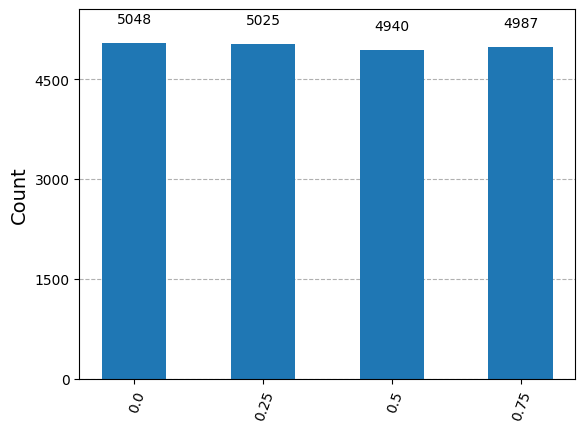

In [18]:
sim = AerSimulator()
transpiled_circuit = transpile(shor_IPE, sim)
job = sim.run(transpiled_circuit, shots=shots) # Run the circuit 1000 times 
count_IPE= job.result().get_counts() 




key_new = [str(int(key,2)/2**t) for key in count_IPE.keys()]
count_new_IPE = dict(zip(key_new, count_IPE.values()))

large_num={}
for key in count_new_IPE.keys():
    if count_new_IPE[key]>100:
        large_num[key]=count_new_IPE[key]

plot_histogram(large_num)

# Noise simulation